In [1]:
! pip install -r requirements.txt --q

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import folium
from tqdm import tqdm
import osmnx as ox
import geopandas as gpd
import datetime
import gc
import sys
import json
import pandas as pd
import torch
import numpy as np
import networkx as nx
from datetime import datetime, timedelta

from torch_geometric.utils import from_networkx
from haversine import haversine, Unit

pd.set_option('display.max_columns', None)

In [3]:
def daynum_to_datetime(daynum):
    """
    Convert a DayNum float to a datetime object.
    
    DayNum 1 corresponds to Nov 1st, 2017, 00:00:00.
    """
    # Reference date: DayNum 1 = Nov 1st, 2017, 00:00:00
    reference_date = datetime(2017, 11, 1, 0, 0, 0)
    
    # Calculate the timedelta from the reference date
    delta = timedelta(days=daynum - 1)
    
    # Add the timedelta to the reference date
    result_datetime = reference_date + delta
    
    return result_datetime


## 1. Preparation

In [4]:
# Create dictionary for mapping of VehId to Vehicle_Type
df_IceHev = pd.read_excel ('VED-master\Data\VED_Static_Data_ICE&HEV.xlsx')
df_IceHev.rename(columns={'Vehicle Type': 'Vehicle_Type'}, inplace=True)
df_PhevEv = pd.read_excel ('VED-master\Data\VED_Static_Data_PHEV&EV.xlsx')
df_PhevEv.rename(columns={'EngineType': 'Vehicle_Type'}, inplace=True)
df_VehId = pd.concat([df_IceHev, df_PhevEv], ignore_index = True)
df_VehId.sort_values(by='VehId', inplace=True)
df_VehId

,VehId,Vehicle_Type,Vehicle Class,Engine Configuration & Displacement,Transmission,Drive Wheels,Generalized_Weight
0,2,ICE,Car,4-FI 2.0L T/C,NO DATA,NO DATA,3500
1,5,HEV,Car,4-GAS/ELECTRIC 2.0L,NO DATA,NO DATA,3500
2,7,ICE,SUV,6-FI 3.6L,AUTOMATIC,NO DATA,4500
3,8,ICE,Car,4-FI 1.5L,5-SP MANUAL,NO DATA,2500
357,9,PHEV,Car,4-GAS/ELECTRIC 1.4L,NO DATA,FWD,4000
...,...,...,...,...,...,...,...
352,616,ICE,NO DATA,V6 3.5L,5-SP Automatic,NO DATA,NO DATA
353,618,ICE,NO DATA,V6 3.5L,4-SP Automatic,NO DATA,NO DATA
354,624,ICE,NO DATA,H-4 2.5L,5-SP Automatic,NO DATA,NO DATA
355,625,ICE,NO DATA,I-4 1.8L,CVT,NO DATA,3000


In [5]:
%%time
df_list = []
input_dir = "datarepo-eved-dataset-549403600cf5/data/eVED/"
file_list = os.listdir(input_dir)
file_list = [file for file in file_list if file.endswith("_week.csv")]

for i in range(len(file_list)):
    df = pd.read_csv(input_dir + file_list[i], low_memory=False)
    print(f"Reading file ({i+1}/{len(file_list)}): {file_list[i]} (len = {len(df)})")
    df = df[df['Energy_Consumption'].notnull()]
    df_list.append(df)

raw_df = pd.concat(df_list)
print("=============================================")
print(f"Total records: {len(raw_df)}")

Reading file (1/54): eVED_171101_week.csv (len = 489414)
Reading file (2/54): eVED_171108_week.csv (len = 535198)
Reading file (3/54): eVED_171115_week.csv (len = 602092)
Reading file (4/54): eVED_171122_week.csv (len = 474329)
Reading file (5/54): eVED_171129_week.csv (len = 531856)
Reading file (6/54): eVED_171206_week.csv (len = 589154)
Reading file (7/54): eVED_171213_week.csv (len = 670084)
Reading file (8/54): eVED_171220_week.csv (len = 539468)
Reading file (9/54): eVED_171227_week.csv (len = 311927)
Reading file (10/54): eVED_180103_week.csv (len = 393498)
Reading file (11/54): eVED_180110_week.csv (len = 550780)
Reading file (12/54): eVED_180117_week.csv (len = 526771)
Reading file (13/54): eVED_180124_week.csv (len = 456757)
Reading file (14/54): eVED_180131_week.csv (len = 479522)
Reading file (15/54): eVED_180207_week.csv (len = 419846)
Reading file (16/54): eVED_180214_week.csv (len = 389642)
Reading file (17/54): eVED_180221_week.csv (len = 285924)
Reading file (18/54): e

In [6]:
print("Total unique vehicles:", raw_df['VehId'].nunique())
print("Total unique trips:",    raw_df[['VehId','Trip']].drop_duplicates().shape[0])

Total unique vehicles: 308
Total unique trips: 24064


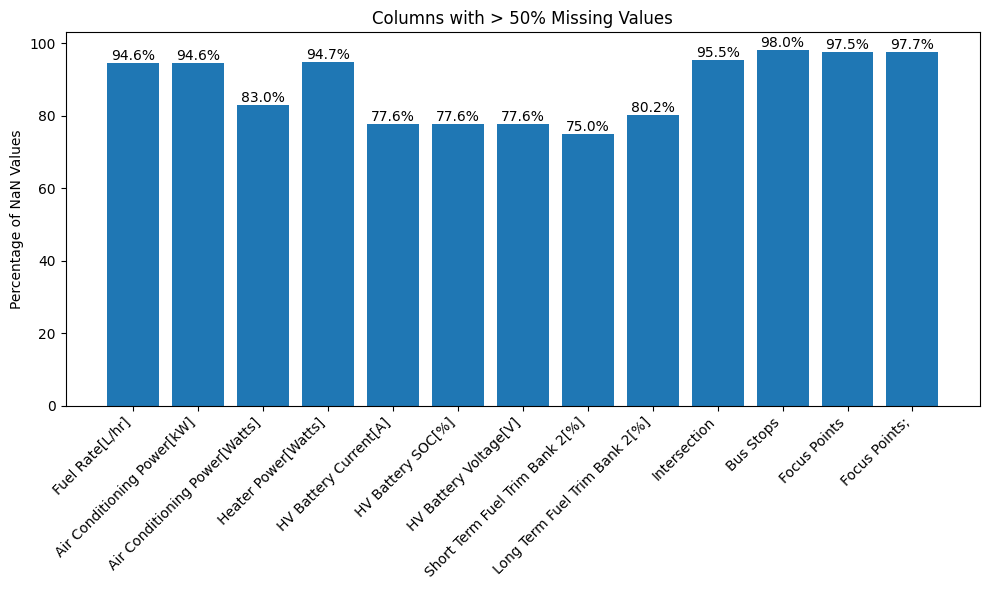

CPU times: total: 10.8 s
Wall time: 11.8 s


In [7]:
%%time
# Drop columns with >50% NaN values
nan_percentages = (raw_df.isna().sum() / len(raw_df)) * 100

# Filter columns with >80% NaN values
high_nan_cols = nan_percentages[nan_percentages > 50]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(high_nan_cols)), high_nan_cols.values)
plt.xticks(range(len(high_nan_cols)), high_nan_cols.index, rotation=45, ha='right')
plt.ylabel('Percentage of NaN Values')  
plt.title('Columns with > 50% Missing Values')

# Add percentage labels on top of bars
for i, v in enumerate(high_nan_cols.values):
    plt.text(i, v, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

raw_df.drop(columns=high_nan_cols.index, inplace=True)

In [8]:
# drop rows with NaN values 
raw_df.dropna(how='any', axis=0, inplace=True)

In [9]:
print("Total unique vehicles:", raw_df['VehId'].nunique())
print("Total unique trips:",    raw_df[['VehId','Trip']].drop_duplicates().shape[0])

Total unique vehicles: 167
Total unique trips: 9009


In [10]:
raw_df = raw_df.merge(df_VehId, on='VehId', how='left')
raw_df

,DayNum,VehId,Trip,Timestamp(ms),Latitude[deg],Longitude[deg],Vehicle Speed[km/h],MAF[g/sec],Engine RPM[RPM],Absolute Load[%],OAT[DegC],Short Term Fuel Trim Bank 1[%],Long Term Fuel Trim Bank 1[%],Elevation Raw[m],Elevation Smoothed[m],Gradient,Energy_Consumption,Matchted Latitude[deg],Matched Longitude[deg],Match Type,Class of Speed Limit,Speed Limit[km/h],Speed Limit with Direction[km/h],Vehicle_Type,Vehicle Class,Engine Configuration & Displacement,Transmission,Drive Wheels,Generalized_Weight
0,85.847662,157.0,2481.0,0.0,42.255103,-83.686560,51.0,4.84,1100.0,17.254902,15.0,2.34375,-9.37500,248.886963,248.886963,0.000000,0.001526,42.255053,-83.686578,0,0.0,64,64.0,ICE,NO DATA,6-FI 3.5L,NO DATA,NO DATA,3500
1,85.847662,157.0,2481.0,1300.0,42.255103,-83.686560,52.0,5.21,1100.0,17.254902,15.0,2.34375,-9.37500,248.886963,248.886963,0.000000,0.001675,42.255053,-83.686578,1,0.0,64,64.0,ICE,NO DATA,6-FI 3.5L,NO DATA,NO DATA,3500
2,85.847662,157.0,2481.0,2000.0,42.255103,-83.686560,52.0,5.21,1095.0,17.254902,15.0,2.34375,-9.37500,248.886963,248.156158,-0.006169,0.001675,42.255053,-83.686578,1,0.0,64,64.0,ICE,NO DATA,6-FI 3.5L,NO DATA,NO DATA,3500
3,85.847662,157.0,2481.0,2900.0,42.254983,-83.685861,52.0,5.21,1095.0,17.254902,15.0,2.34375,-9.37500,247.059952,247.790756,0.000000,0.001675,42.254925,-83.685880,0,0.0,72,72.0,ICE,NO DATA,6-FI 3.5L,NO DATA,NO DATA,3500
4,85.847662,157.0,2481.0,3700.0,42.254983,-83.685861,53.0,7.27,1095.0,17.254902,15.0,2.34375,-9.37500,247.059952,247.425354,0.000000,0.002382,42.254925,-83.685880,1,0.0,72,72.0,ICE,NO DATA,6-FI 3.5L,NO DATA,NO DATA,3500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5455857,375.499059,458.0,2473.0,229100.0,42.258769,-83.677832,71.0,15.12,1195.0,45.490196,4.0,-3.12500,-0.78125,236.344833,236.389923,0.000000,0.006860,42.258992,-83.677841,1,0.0,72,72.0,HEV,NO DATA,4-GAS/ELECTRIC 2.4L,NO DATA,NO DATA,3500
5455858,375.499059,458.0,2473.0,230200.0,42.258769,-83.677832,70.0,12.60,1302.0,45.490196,4.0,-3.12500,-0.78125,236.344833,236.435013,0.000561,0.005636,42.258992,-83.677841,1,0.0,72,72.0,HEV,NO DATA,4-GAS/ELECTRIC 2.4L,NO DATA,NO DATA,3500
5455859,375.499059,458.0,2473.0,231000.0,42.258805,-83.676859,70.0,12.60,1302.0,45.490196,4.0,-3.12500,-0.78125,236.570282,236.480103,0.000000,0.005636,42.259011,-83.676867,0,0.0,72,72.0,HEV,NO DATA,4-GAS/ELECTRIC 2.4L,NO DATA,NO DATA,3500
5455860,375.499059,458.0,2473.0,231200.0,42.258805,-83.676859,69.0,12.60,1302.0,45.490196,4.0,-1.56250,-0.78125,236.570282,236.570282,0.000000,0.005646,42.259011,-83.676867,1,0.0,72,72.0,HEV,NO DATA,4-GAS/ELECTRIC 2.4L,NO DATA,NO DATA,3500


In [12]:
for col in df_VehId.columns:
    print(f"{col}: {raw_df[col].value_counts().get('NO DATA', 0) / len(raw_df) * 100:.2f}% 'NO DATA'")

VehId: 0.00% 'NO DATA'
Vehicle_Type: 0.00% 'NO DATA'
Vehicle Class: 99.82% 'NO DATA'
Engine Configuration & Displacement: 0.00% 'NO DATA'
Transmission: 92.23% 'NO DATA'
Drive Wheels: 100.00% 'NO DATA'
Generalized_Weight: 0.47% 'NO DATA'


In [13]:
raw_df.drop(columns=['Vehicle Class', 'Transmission', 'Drive Wheels'], inplace=True)

In [14]:
raw_df = raw_df[(raw_df['Vehicle_Type']!= 'NO DATA') & (raw_df['Generalized_Weight']!= 'NO DATA')]
raw_df['VehId'] = raw_df['VehId'].astype('Int64')
raw_df['Trip']  = raw_df['Trip'].astype('Int64')
raw_df['Timestamp(ms)'] = raw_df['Timestamp(ms)'].astype('Int64')
raw_df['Vehicle Speed[km/h]'] = raw_df['Vehicle Speed[km/h]'].astype('Int64')
raw_df['Engine RPM[RPM]'] = raw_df['Engine RPM[RPM]'].astype('Int64')
raw_df['OAT[DegC]'] = raw_df['OAT[DegC]'].astype('Int64')
raw_df

C:\Users\MinhVu\AppData\Local\Temp\ipykernel_6120\2691859901.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df['VehId'] = raw_df['VehId'].astype('Int64')
C:\Users\MinhVu\AppData\Local\Temp\ipykernel_6120\2691859901.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df['Trip']  = raw_df['Trip'].astype('Int64')
C:\Users\MinhVu\AppData\Local\Temp\ipykernel_6120\2691859901.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,DayNum,VehId,Trip,Timestamp(ms),Latitude[deg],Longitude[deg],Vehicle Speed[km/h],MAF[g/sec],Engine RPM[RPM],Absolute Load[%],OAT[DegC],Short Term Fuel Trim Bank 1[%],Long Term Fuel Trim Bank 1[%],Elevation Raw[m],Elevation Smoothed[m],Gradient,Energy_Consumption,Matchted Latitude[deg],Matched Longitude[deg],Match Type,Class of Speed Limit,Speed Limit[km/h],Speed Limit with Direction[km/h],Vehicle_Type,Engine Configuration & Displacement,Generalized_Weight
0,85.847662,157,2481,0,42.255103,-83.686560,51,4.84,1100,17.254902,15,2.34375,-9.37500,248.886963,248.886963,0.000000,0.001526,42.255053,-83.686578,0,0.0,64,64.0,ICE,6-FI 3.5L,3500
1,85.847662,157,2481,1300,42.255103,-83.686560,52,5.21,1100,17.254902,15,2.34375,-9.37500,248.886963,248.886963,0.000000,0.001675,42.255053,-83.686578,1,0.0,64,64.0,ICE,6-FI 3.5L,3500
2,85.847662,157,2481,2000,42.255103,-83.686560,52,5.21,1095,17.254902,15,2.34375,-9.37500,248.886963,248.156158,-0.006169,0.001675,42.255053,-83.686578,1,0.0,64,64.0,ICE,6-FI 3.5L,3500
3,85.847662,157,2481,2900,42.254983,-83.685861,52,5.21,1095,17.254902,15,2.34375,-9.37500,247.059952,247.790756,0.000000,0.001675,42.254925,-83.685880,0,0.0,72,72.0,ICE,6-FI 3.5L,3500
4,85.847662,157,2481,3700,42.254983,-83.685861,53,7.27,1095,17.254902,15,2.34375,-9.37500,247.059952,247.425354,0.000000,0.002382,42.254925,-83.685880,1,0.0,72,72.0,ICE,6-FI 3.5L,3500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5455857,375.499059,458,2473,229100,42.258769,-83.677832,71,15.12,1195,45.490196,4,-3.12500,-0.78125,236.344833,236.389923,0.000000,0.006860,42.258992,-83.677841,1,0.0,72,72.0,HEV,4-GAS/ELECTRIC 2.4L,3500
5455858,375.499059,458,2473,230200,42.258769,-83.677832,70,12.60,1302,45.490196,4,-3.12500,-0.78125,236.344833,236.435013,0.000561,0.005636,42.258992,-83.677841,1,0.0,72,72.0,HEV,4-GAS/ELECTRIC 2.4L,3500
5455859,375.499059,458,2473,231000,42.258805,-83.676859,70,12.60,1302,45.490196,4,-3.12500,-0.78125,236.570282,236.480103,0.000000,0.005636,42.259011,-83.676867,0,0.0,72,72.0,HEV,4-GAS/ELECTRIC 2.4L,3500
5455860,375.499059,458,2473,231200,42.258805,-83.676859,69,12.60,1302,45.490196,4,-1.56250,-0.78125,236.570282,236.570282,0.000000,0.005646,42.259011,-83.676867,1,0.0,72,72.0,HEV,4-GAS/ELECTRIC 2.4L,3500


In [15]:
# Convert Timestamp(ms) to seconds and add to base_date
raw_df.drop(columns=['Elevation Raw[m]','Match Type', 'Class of Speed Limit', 'Speed Limit with Direction[km/h]' ], inplace=True)

C:\Users\MinhVu\AppData\Local\Temp\ipykernel_6120\2560209779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df.drop(columns=['Elevation Raw[m]','Match Type', 'Class of Speed Limit', 'Speed Limit with Direction[km/h]' ], inplace=True)


In [16]:
raw_df.to_csv("DATA/raw_data.csv", index=False)

In [17]:
# Get initial memory info
before = len(gc.get_objects())
print(f"Objects before: {before}")
# Clear large dataframes and lists
del df_list
del raw_df
del df_IceHev
del df_PhevEv
del df_VehId
del df
del high_nan_cols
del nan_percentages

# Force garbage collection
gc.collect()

# Get memory info after cleanup
after = len(gc.get_objects())
print(f"Objects after: {after}")

Objects before: 453319
Objects after: 442964


## 2. Preprocessing

In [18]:
full_df = pd.read_csv("DATA/raw_data.csv", low_memory=False)
full_df

,DayNum,VehId,Trip,Timestamp(ms),Latitude[deg],Longitude[deg],Vehicle Speed[km/h],MAF[g/sec],Engine RPM[RPM],Absolute Load[%],OAT[DegC],Short Term Fuel Trim Bank 1[%],Long Term Fuel Trim Bank 1[%],Elevation Smoothed[m],Gradient,Energy_Consumption,Matchted Latitude[deg],Matched Longitude[deg],Speed Limit[km/h],Vehicle_Type,Engine Configuration & Displacement,Generalized_Weight
0,85.847662,157,2481,0,42.255103,-83.686560,51,4.84,1100,17.254902,15,2.34375,-9.37500,248.886963,0.000000,0.001526,42.255053,-83.686578,64,ICE,6-FI 3.5L,3500
1,85.847662,157,2481,1300,42.255103,-83.686560,52,5.21,1100,17.254902,15,2.34375,-9.37500,248.886963,0.000000,0.001675,42.255053,-83.686578,64,ICE,6-FI 3.5L,3500
2,85.847662,157,2481,2000,42.255103,-83.686560,52,5.21,1095,17.254902,15,2.34375,-9.37500,248.156158,-0.006169,0.001675,42.255053,-83.686578,64,ICE,6-FI 3.5L,3500
3,85.847662,157,2481,2900,42.254983,-83.685861,52,5.21,1095,17.254902,15,2.34375,-9.37500,247.790756,0.000000,0.001675,42.254925,-83.685880,72,ICE,6-FI 3.5L,3500
4,85.847662,157,2481,3700,42.254983,-83.685861,53,7.27,1095,17.254902,15,2.34375,-9.37500,247.425354,0.000000,0.002382,42.254925,-83.685880,72,ICE,6-FI 3.5L,3500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5430049,375.499059,458,2473,229100,42.258769,-83.677832,71,15.12,1195,45.490196,4,-3.12500,-0.78125,236.389923,0.000000,0.006860,42.258992,-83.677841,72,HEV,4-GAS/ELECTRIC 2.4L,3500
5430050,375.499059,458,2473,230200,42.258769,-83.677832,70,12.60,1302,45.490196,4,-3.12500,-0.78125,236.435013,0.000561,0.005636,42.258992,-83.677841,72,HEV,4-GAS/ELECTRIC 2.4L,3500
5430051,375.499059,458,2473,231000,42.258805,-83.676859,70,12.60,1302,45.490196,4,-3.12500,-0.78125,236.480103,0.000000,0.005636,42.259011,-83.676867,72,HEV,4-GAS/ELECTRIC 2.4L,3500
5430052,375.499059,458,2473,231200,42.258805,-83.676859,69,12.60,1302,45.490196,4,-1.56250,-0.78125,236.570282,0.000000,0.005646,42.259011,-83.676867,72,HEV,4-GAS/ELECTRIC 2.4L,3500


In [48]:

class Node:
    def __init__(self, lat, lon, raw_lat, raw_lon, ele):
        self.lat = lat
        self.lon = lon
        self.raw_lat = raw_lat
        self.raw_lon = raw_lon
        self.ele = ele  

    def __str__(self):
        return f"""Node({', '.join(f'{key}="{value}"' for key, value in self.__dict__.items())})"""

    def to_dict(self):
        # Convert the object to a dictionary
        return self.__dict__

class Edge:
    def __init__(self, df):
        start_row = df.sort_values('Timestamp(ms)').iloc[0]
        self.start_date = daynum_to_datetime(start_row['DayNum'])
        self.start_node = Node(
            lat     = start_row['Matchted Latitude[deg]'], 
            lon     = start_row['Matched Longitude[deg]'], 
            raw_lat = start_row['Latitude[deg]'],
            raw_lon = start_row['Longitude[deg]'],
            ele     = start_row['Elevation Smoothed[m]']
            )

        end_row = df.sort_values('Timestamp(ms)').iloc[-1]
        self.end_date = daynum_to_datetime(end_row['DayNum'])
        self.end_node = Node(
            lat     = end_row['Matchted Latitude[deg]'], 
            lon     = end_row['Matched Longitude[deg]'], 
            raw_lat = end_row['Latitude[deg]'],
            raw_lon = end_row['Longitude[deg]'],
            ele     = end_row['Elevation Smoothed[m]'])      

        self.distance = haversine((self.start_node.lat, self.start_node.lon), (self.end_node.lat, self.end_node.lon), unit=Unit.METERS)
        self.time = (end_row['Timestamp(ms)'] - start_row['Timestamp(ms)']) / 1000  # Convert milliseconds to seconds

        self.speed              = float(df['Vehicle Speed[km/h]'].mean())
        self.maf                = float(df['MAF[g/sec]'].mean())
        self.engine_rpm         = float(df['Engine RPM[RPM]'].mean())
        self.absolute_load      = float(df['Absolute Load[%]'].mean())
        self.oat                = float(df['OAT[DegC]'].mean())
        self.stft_bank1         = float(df['Short Term Fuel Trim Bank 1[%]'].mean())
        self.ltft_bank1         = float(df['Long Term Fuel Trim Bank 1[%]'].mean())
        self.gradient           = float(df['Gradient'].mean())
        self.speed_limit        = float(df['Speed Limit[km/h]'].astype('Int64').mean())
        self.energy_consumption = float(df['Energy_Consumption'].mean())

    def __str__(self):
        return f"""Edge({', '.join(f'{key}="{value}"' for key, value in self.__dict__.items())})"""

    def to_dict(self):
        # Convert the object to a dictionary
        return self.__dict__

class Trip:
    def __init__(self, trip_df, data=None):
        self.vehicle_id = trip_df['VehId'].values[0]
        self.trip_id = str(trip_df['Trip'].values[0]) + "_" + str(trip_df['VehId'].values[0])

        self.start_date = daynum_to_datetime(min(trip_df['DayNum']))
        self.running_time = max(trip_df['Timestamp(ms)']) / 1000
        self.end_date = self.start_date + timedelta(seconds=self.running_time)
        self.vehicle_type = trip_df['Vehicle_Type'].values[0]
        self.weight = trip_df['Generalized_Weight'].values[0]
        self.engine = trip_df['Engine Configuration & Displacement'].values[0]
        
        self.edge_list = []
        sorted_trip_df = trip_df.sort_values('Timestamp(ms)').reset_index(drop=True)
        
        for i in range(len(sorted_trip_df) - 1):
            # Create a segment dataframe with current and next point
            segment_df = sorted_trip_df.iloc[i:i+2]
            self.edge_list.append(Edge(segment_df))
        
        self.node_list = [edge.start_node for edge in self.edge_list] + [self.edge_list[-1].end_node]

    def visualize_trip(self):
        # Create a map centered on the mean latitude and longitude of the trip
        
        center_lat = pd.Series([node.lat for node in self.node_list]).mean()
        center_lon = pd.Series([node.lon for node in self.node_list]).mean()
        trip_map = folium.Map(location=[center_lat, center_lon], zoom_start=14)

        # Add a polyline to show the trip route
        folium.PolyLine(
            [[node.lat, node.lon] for node in self.node_list],
            color='blue',
            weight=3,
            opacity=0.9,
            tooltip='Trip route'
        ).add_to(trip_map)
        
        folium.PolyLine(
            [[node.raw_lat, node.raw_lon] for node in self.node_list],
            color='#ADD8E6',
            weight=5,
            opacity=0.7,
            tooltip='raw GPS route'
        ).add_to(trip_map)

        folium.Marker(
            location=[self.node_list[0].lat, self.node_list[0].lon],
            popup='Start',
            icon=folium.Icon(color='green', icon='play')
        ).add_to(trip_map)

        folium.Marker(
            location=[self.node_list[-1].lat, self.node_list[-1].lon],
            popup='End',
            icon=folium.Icon(color='red', icon='stop')
        ).add_to(trip_map)
        
        return trip_map

    def __str__(self):
        return f"""Trip({', '.join(f'{key}="{value}"' for key, value in self.__dict__.items())})"""

    def to_dict(self):
        # Convert the object to a dictionary
        return self.__dict__

In [49]:
long_trip  = Trip(full_df[(full_df['VehId'] == 575) & (full_df['Trip'] == 1639)])
short_trip = Trip(full_df[(full_df['VehId'] == 566) & (full_df['Trip'] == 861)])

In [50]:
short_trip.visualize_trip()

Trip length statistics:
Min data points: 1
Max data points: 6724
Mean data points: 605.22
Median data points: 477.0
Total trips: 8972

Top 5 longest trips:
      VehId  Trip  row_count
8151    575  1639       6724
1935    349  1555       6158
8173    575  1790       5102
6215    465  2117       4990
1903    349  1336       4725

Top 5 shortest trips:
      VehId  Trip  row_count
7713    557  1242          1
8771    592   543         13
7903    566   861         72
6738    477  1466         78
6651    477   875         82

Vehicle trip length statistics:
     VehId  min_rows  max_rows     avg_rows  num_trips
152    575        97      6724   887.149306        288
65     349       105      6158   814.160256        156
122    465       102      4990  1061.432624        141
135    503       117      4706   512.217391         23
33     240       234      4645  1062.285714          7
121    463       133      4550   890.833333         36
144    549       106      4306   622.357143         56


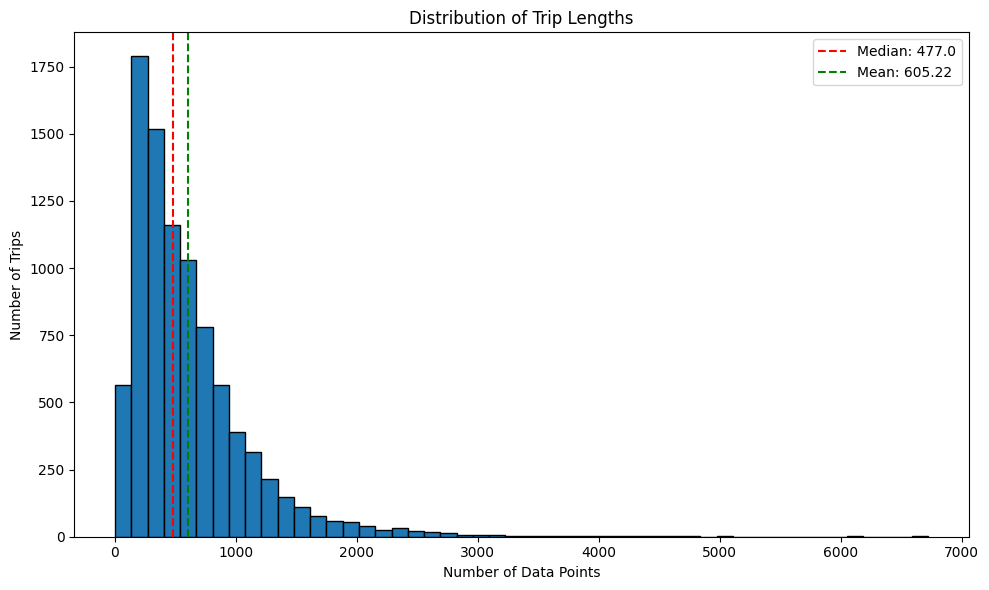

In [26]:
# Compute statistics on trips and vehicle types
trip_stats = full_df.groupby(['VehId', 'Trip']).size().reset_index(name='row_count')

# Calculate summary statistics on trip lengths
print("Trip length statistics:")
print(f"Min data points: {trip_stats['row_count'].min()}")
print(f"Max data points: {trip_stats['row_count'].max()}")
print(f"Mean data points: {trip_stats['row_count'].mean():.2f}")
print(f"Median data points: {trip_stats['row_count'].median()}")
print(f"Total trips: {len(trip_stats)}")

# Find trips with most data points
print("\nTop 5 longest trips:")
print(trip_stats.sort_values('row_count', ascending=False).head(5))

# Find trips with fewest data points
print("\nTop 5 shortest trips:")
print(trip_stats.sort_values('row_count').head(5))

# For each VehId, find the trip with min and max row counts
veh_trip_minmax = trip_stats.groupby('VehId').agg(
    min_rows=('row_count', 'min'),
    max_rows=('row_count', 'max'),
    avg_rows=('row_count', 'mean'),
    num_trips=('row_count', 'count')
).reset_index()

print("\nVehicle trip length statistics:")
print(veh_trip_minmax.sort_values('max_rows', ascending=False).head(10))

# Count trips by vehicle type
vehicle_trip_counts = full_df.groupby('Vehicle_Type')[['VehId', 'Trip']].apply(
    lambda x: len(x.drop_duplicates())
).reset_index(name='trip_count')

print("\nTrips by vehicle type:")
print(vehicle_trip_counts)

# Plot histogram of trip lengths
plt.figure(figsize=(10, 6))
plt.hist(trip_stats['row_count'], bins=50, edgecolor='black')
plt.xlabel('Number of Data Points')
plt.ylabel('Number of Trips')
plt.title('Distribution of Trip Lengths')
plt.axvline(trip_stats['row_count'].median(), color='r', linestyle='--', label=f'Median: {trip_stats["row_count"].median()}')
plt.axvline(trip_stats['row_count'].mean(), color='g', linestyle='--', label=f'Mean: {trip_stats["row_count"].mean():.2f}')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
temp_df = full_df[(full_df['VehId'] == 575) & (full_df['Trip'] == 1639)]
# Create a map centered on the mean latitude and longitude of the trip
center_lat = temp_df['Matchted Latitude[deg]'].mean()
center_lon = temp_df['Matched Longitude[deg]'].mean()
trip_map = folium.Map(location=[center_lat, center_lon], zoom_start=14)

# Create a list of [lat, lon] coordinates for the trip
coordinates = temp_df[['Matchted Latitude[deg]', 'Matched Longitude[deg]']].values.tolist()

# Add a polyline to show the trip route
folium.PolyLine(
    coordinates,
    color='blue',
    weight=3,
    opacity=0.7,
).add_to(trip_map)

# Add markers for start and end points
start_point = coordinates[0]
end_point = coordinates[-1]

folium.Marker(
    location=start_point,
    popup='Start',
    icon=folium.Icon(color='green', icon='play')
).add_to(trip_map)

folium.Marker(
    location=end_point,
    popup='End',
    icon=folium.Icon(color='red', icon='stop')
).add_to(trip_map)

trip_map

In [30]:
coordinates

[[42.274468, -83.67417],
 [42.274468, -83.67417],
 [42.274468, -83.67417],
 [42.274468, -83.67417],
 [42.274468, -83.67417],
 [42.274551, -83.674429],
 [42.274551, -83.674429],
 [42.274551, -83.674429],
 [42.274551, -83.674429],
 [42.274551, -83.674429],
 [42.274463, -83.674698],
 [42.274463, -83.674698],
 [42.274463, -83.674698],
 [42.274463, -83.674698],
 [42.274463, -83.674698],
 [42.274463, -83.674698],
 [42.274427, -83.675077],
 [42.274427, -83.675077],
 [42.274427, -83.675077],
 [42.274427, -83.675077],
 [42.274427, -83.675077],
 [42.274425, -83.675499],
 [42.274425, -83.675499],
 [42.274425, -83.675499],
 [42.274425, -83.675499],
 [42.274425, -83.675499],
 [42.274425, -83.675499],
 [42.274425, -83.675499],
 [42.274442, -83.676104],
 [42.274442, -83.676104],
 [42.274442, -83.676104],
 [42.274456, -83.676571],
 [42.274456, -83.676571],
 [42.274456, -83.676571],
 [42.274456, -83.676571],
 [42.274456, -83.676571],
 [42.274475, -83.677073],
 [42.274475, -83.677073],
 [42.274475, -83.

In [ ]:
print(temp_df['Matchted Latitude[deg]'].min())
print(temp_df['Matchted Latitude[deg]'].max())
print(temp_df['Matched Longitude[deg]'].min())
print(temp_df['Matched Longitude[deg]'].max())

In [ ]:
north, south, east, west = 42.245611, 42.259011, -83.680852, -83.676867
# Download road network from OSM within specified coordinates
G = ox.graph_from_bbox((north, south, east, west), network_type='drive')

# Plot the graph
fig, ax = ox.plot_graph(G, figsize=(10, 10))

In [ ]:
temp_df.sort_values('Timestamp(ms)')[['Matchted Latitude[deg]', 'Matched Longitude[deg]']].drop_duplicates().values.tolist()

In [ ]:
class Trip:
    def __init__(self, trip_df, data=None):
        self.vehicle_id = trip_df['VehId'].values[0]
        self.trip_id = trip_df['Trip'].values[0] + "_" + trip_df['VehId'].values[0]
        
    # def _load_data(self):
    #     """Load trip data from the full dataframe"""
    #     if 'full_df' in globals():
    #         return full_df[(full_df['VehId'] == self.vehicle_id) & 
    #                       (full_df['Trip'] == self.trip_id)].copy().reset_index(drop=True)
    #     else:
    #         raise ValueError("Full dataframe not available")
    
    # def get_duration(self):
    #     """Return trip duration in seconds"""
    #     if self.data is None or len(self.data) == 0:
    #         return 0
    #     max_timestamp = self.data['Timestamp(ms)'].max()
    #     min_timestamp = self.data['Timestamp(ms)'].min()
    #     return (max_timestamp - min_timestamp) / 1000  # Convert to seconds
    
    # def get_distance(self):
    #     """Estimate trip distance in meters using haversine formula"""
    #     if self.data is None or len(self.data) < 2:
    #         return 0
        
    #     total_distance = 0
    #     for i in range(len(self.data) - 1):
    #         curr_node = (self.data.loc[i, 'Matchted Latitude[deg]'], 
    #                      self.data.loc[i, 'Matched Longitude[deg]'])
    #         next_node = (self.data.loc[i+1, 'Matchted Latitude[deg]'], 
    #                      self.data.loc[i+1, 'Matched Longitude[deg]'])
            
    #         distance = haversine(curr_node, next_node, unit=Unit.METERS)
    #         total_distance += distance
            
    #     return total_distance
    
    # def get_total_energy(self):
    #     """Return total energy consumption for the trip"""
    #     if self.data is None or len(self.data) == 0:
    #         return 0
    #     return self.data['Energy_Consumption'].sum()
    
    # def get_average_speed(self):
    #     """Return average speed in km/h"""
    #     if self.data is None or len(self.data) == 0:
    #         return 0
    #     return self.data['Vehicle Speed[km/h]'].mean()
    
    # def get_max_speed(self):
    #     """Return maximum speed in km/h"""
    #     if self.data is None or len(self.data) == 0:
    #         return 0
    #     return self.data['Vehicle Speed[km/h]'].max()
    
    # def get_vehicle_type(self):
    #     """Return vehicle type"""
    #     if self.data is None or len(self.data) == 0:
    #         return None
    #     return self.data['Vehicle_Type'].iloc[0]
    
    # def get_summary(self):
    #     """Return summary statistics of the trip"""
    #     return {
    #         'vehicle_id': self.vehicle_id,
    #         'trip_id': self.trip_id,
    #         'duration_sec': self.get_duration(),
    #         'distance_m': self.get_distance(),
    #         'total_energy': self.get_total_energy(),
    #         'avg_speed_kmh': self.get_average_speed(),
    #         'max_speed_kmh': self.get_max_speed(),
    #         'vehicle_type': self.get_vehicle_type(),
    #         'data_points': len(self.data) if self.data is not None else 0
    #     }
    
    # def plot_trip(self, figsize=(15, 10)):
    #     """Generate plots for trip visualization"""
    #     if self.data is None or len(self.data) == 0:
    #         print("No data available for plotting")
    #         return
            
    #     import matplotlib.pyplot as plt
        
    #     plt.figure(figsize=figsize)
        
    #     # Plot 1: Speed over time
    #     plt.subplot(2, 2, 1)
    #     plt.plot(self.data['Timestamp(ms)'] / 1000, self.data['Vehicle Speed[km/h]'], 'b-')
    #     plt.xlabel('Time (seconds)')
    #     plt.ylabel('Speed (km/h)')
    #     plt.title('Speed Profile')
    #     plt.grid(True)
        
    #     # Plot 2: Energy consumption over time
    #     plt.subplot(2, 2, 2)
    #     plt.plot(self.data['Timestamp(ms)'] / 1000, self.data['Energy_Consumption'], 'r-')
    #     plt.xlabel('Time (seconds)')
    #     plt.ylabel('Energy Consumption')
    #     plt.title('Energy Consumption Profile')
    #     plt.grid(True)
        
    #     # Plot 3: Elevation over time
    #     plt.subplot(2, 2, 3)
    #     plt.plot(self.data['Timestamp(ms)'] / 1000, self.data['Elevation Smoothed[m]'], 'g-')
    #     plt.xlabel('Time (seconds)')
    #     plt.ylabel('Elevation (m)')
    #     plt.title('Elevation Profile')
    #     plt.grid(True)
        
    #     # Plot 4: Trip route on map (if folium is available)
    #     plt.subplot(2, 2, 4)
    #     plt.scatter(self.data['Matched Longitude[deg]'], self.data['Matchted Latitude[deg]'], 
    #                c=self.data['Timestamp(ms)'], cmap='viridis', s=10)
    #     plt.xlabel('Longitude')
    #     plt.ylabel('Latitude')
    #     plt.title('Trip Route')
    #     plt.grid(True)
    #     plt.colorbar(label='Time')
        
    #     plt.tight_layout()
    #     plt.show()

In [ ]:

%%time
# 15mins
G = nx.DiGraph()

# Iterate through trips to add nodes and edges
for (veh_id, trip), trip_df in tqdm(full_df.groupby(['VehId', 'Trip'])):
    trip_df = trip_df.reset_index(drop=True)

    for i in range(len(trip_df) - 1):
        current = trip_df.loc[i]
        next_point = trip_df.loc[i + 1]

        # Node definitions (latitude, longitude)
        curr_node = (current['Matchted Latitude[deg]'], current['Matched Longitude[deg]'])
        next_node = (next_point['Matchted Latitude[deg]'], next_point['Matched Longitude[deg]'])

        # Add node attributes
        if curr_node not in G:
            G.add_node(curr_node,
                    latitude=current['Matchted Latitude[deg]'],
                    longitude=current['Matched Longitude[deg]'],
                    elevation=current['Elevation Smoothed[m]'])

        if next_node not in G:
            G.add_node(next_node,
                    latitude=next_point['Matchted Latitude[deg]'],
                    longitude=next_point['Matched Longitude[deg]'],
                    elevation=next_point['Elevation Smoothed[m]'])

        # Compute distance
        distance = haversine(curr_node, next_node, unit=Unit.METERS)

        # Edge attributes
        G.add_edge(curr_node, 
                next_node,
                distance=distance,
                gradient=next_point['Gradient'],
                energy_consumption=next_point['Energy_Consumption'],
                vehicle_speed=next_point['Vehicle Speed[km/h]'],
                temperature=next_point['OAT[DegC]'],
                engine_rpm=next_point['Engine RPM[RPM]'],
                absolute_load=next_point['Absolute Load[%]'])


In [ ]:
# Convert to PyTorch Geometric format (automatically handles indexing)
pyg_data = from_networkx(G)

# Example of normalization (optional but recommended)
# Normalize Node Elevation
elevation = torch.tensor([attr['elevation'] for _, attr in G.nodes(data=True)], dtype=torch.float32)
elev_mean, elev_std = elevation.mean(), elevation.std()
pyg_data.x = ((elevation - elev_mean) / elev_std).unsqueeze(1)  # Node features in PyG (N, 1)

# Normalize Edge attributes
edge_attrs = ['distance', 'gradient', 'energy_consumption', 'vehicle_speed',
            'temperature', 'engine_rpm', 'absolute_load']

edge_features = []
for attr in edge_attrs:
    vals = torch.tensor([G[u][v][attr] for u, v in G.edges()], dtype=torch.float32)
    mean, std = vals.mean(), vals.std()
    normalized = (vals - mean) / std
    edge_features.append(normalized.unsqueeze(1))

# Concatenate edge features
pyg_data.edge_attr = torch.cat(edge_features, dim=1)

# Check resulting PyG data
print(pyg_data)
print("Node feature shape:", pyg_data.x.shape)
print("Edge feature shape:", pyg_data.edge_attr.shape)
